#### I. Ex. 1 | Aidoghmoush Reservoir, Iran

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

%matplotlib inline

#### import data and describe

In [2]:
db = pd.read_csv('aydoghmos_monthly.csv', index_col=0)

In [3]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, 2006-12-31 to 2021-01-31
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Input [MCM]       170 non-null    float64
 1   Demand [MCM]      170 non-null    float64
 2   Evaporation [mm]  170 non-null    float64
dtypes: float64(3)
memory usage: 5.3+ KB


In [4]:
db.describe()

,Input [MCM],Demand [MCM],Evaporation [mm]
count,170.000000,170.000000,170.000000
mean,6.950844,3.627600,3.298251
std,10.773350,5.064102,3.356980
min,0.068256,0.000000,0.000000
25%,0.753624,0.761000,0.082230
50%,2.912544,1.931000,3.712398
75%,7.182432,4.178750,4.275281
max,53.456544,36.146000,27.976000


In [5]:
D = np.array(db.iloc[:,1])
I = np.array(db.iloc[:,0])
Ev_mm = np.array(db.iloc[:,2])
Smin, Smax = 8.9, 145.7

#### 1. Simulation model

In [6]:
def A_func(X):
    return (.056*X+.798)/1000

In [7]:
def reliability_vol(R, D):
    Def = D-R
    return 1-(np.sum(Def)/np.sum(D))

In [8]:
def reliability_prob(R, D):
    count = np.sum(R==D)
    prob = count/len(D)
    return prob

In [9]:
def resiliancy(R, D):
    stat = R!=D
    count = 0
    for i in range(len(stat)-1):
        if (stat[i]==0)and(stat[i+1]==1):
            count += 1
    denom = np.sum(stat)
    return count/denom

In [10]:
def reservior_sim(R, D, I, Ev_mm, Smin, Smax):
    time_frame = len(D)
    S = np.zeros(time_frame+1)
    Sp = np.zeros(time_frame)
    S[0] = Smin
    for t in range(time_frame):
        AW=S[t]+I[t]-R[t]
        Sp[t]=np.average((np.abs(AW-Smax),AW-Smax))
        A = A_func(S[t])
        S[t+1] = AW-Sp[t]-(A*Ev_mm[t])
        S[t+1] = AW-Sp[t]-Ev_mm[t]
        
    Def = D-R
    penalty_1 = np.sum(np.where(S<Smin,Smin-S,0))
    penalty_2 = np.sum(np.where(S>Smax,S-Smax,0))
    penalty_3 = np.sum(np.where(R<0,-R,0))
    penalty_4 = np.sum(np.where(R>D,R>D,0))
    penalties = 100*penalty_1 + 100*penalty_2 + 100*penalty_3 + 100*penalty_4
    penalized = (np.sum(Def)+penalties)/np.sum(D)
    of_unpenalzied = np.sum(Def)/np.sum(D)
    return penalized, of_unpenalzied, S, Sp, Def

In [11]:
def obj_func(X):
    return reservior_sim(X, D, I, Ev_mm, Smin, Smax)[0]

#### 2. Optimization 

##### I. STML

In [12]:
def boundery_checker(pop, min_val, max_val):
    adj_pop = np.where(pop<min_val, min_val, pop)
    adj_pop = np.where(adj_pop>max_val, max_val, adj_pop)
    return adj_pop

def init_genrator_tlbo(min_val, max_val, num_variables, pop_size):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    indeces = np.argsort(results)
    return pop[indeces]

def teacher_phase(pop, pop_size, obj_func, min_val, max_val):
    teacher = pop[0]
    center = np.mean(pop, axis=0)
    rand = np.random.uniform(0,1,size=(pop_size,1))
    teacher_factor = np.random.choice(np.arange(1,3), size=(pop_size,1))
    diff = rand*(teacher-center*teacher_factor)
    pop_new = pop + diff
    pop_new = boundery_checker(pop_new, min_val, max_val)
    results = np.apply_along_axis(obj_func, 1, pop)
    results_new = np.apply_along_axis(obj_func, 1, pop_new)
    return np.where((results_new<results).reshape(-1,1), pop_new, pop)

def learner_phase(pop, pop_size, obj_func, min_val, max_val):
    rand = np.random.uniform(0,1,size=(pop_size,1))
    pop_new = np.zeros_like(pop)
    for i in range(pop_size):
        x, y = np.sort(np.random.choice(np.arange(pop_size), size=2, replace=False))
        pop_new[i] = pop[i] + rand[i]*(pop[x]-pop[y])
    pop_new = boundery_checker(pop_new, min_val, max_val)
    pop_overall = np.concatenate((pop, pop_new), axis=0)
    pop_overall = sorting_pop(pop_overall, obj_func)
    return pop_overall[:pop_size]

def tlbo(pop_size, iteration, min_val, max_val, num_variables, obj_func):
    NFE_value = 0
    pop = init_genrator_tlbo(min_val, max_val, num_variables, pop_size)
    pop = sorting_pop(pop, obj_func)
    for i in range(iteration):
        pop = teacher_phase(pop, pop_size, obj_func, min_val, max_val)
        pop = sorting_pop(pop, obj_func)
        pop = learner_phase(pop, pop_size, obj_func, min_val, max_val)
        NFE_value += (3*pop_size)
    return pop[0], obj_func(pop[0]), NFE_value

def init_generator(pop_size_min, pop_size_max, iteration_min, iteration_max):
    return np.random.uniform(np.array([pop_size_min,iteration_min]),np.array([pop_size_max,iteration_max]),size=2).astype(int)

def exploratory_move(X, mu, NFE_value, min_val, max_val, num_variables, obj_func):
    mesh = (mu*np.eye(len(X)) + X).astype(int)
    sim_results = np.zeros(shape=(len(mesh), num_variables))
    eval_results = np.zeros(len(mesh))
    for index in range(len(mesh)):
        array, of_best, NFE = tlbo(mesh[index][0], mesh[index][1], min_val, max_val, num_variables, obj_func)
        sim_results[index] = array
        eval_results[index] = of_best
        NFE_value += NFE
    return mesh, eval_results, sim_results, NFE_value  

def pattern_move(current_base, previous_base, NFE_value, min_val, max_val, num_variables, obj_func, alpha,
                 pop_size_min, pop_size_max, iteration_min, iteration_max):
    current_base, previous_base = np.array(current_base), np.array(previous_base)
    X_new = previous_base + alpha*(current_base-previous_base)
    sim_result, of_new, NFE = tlbo(X_new[0], X_new[1], min_val, max_val, num_variables, obj_func)
    NFE_value += NFE
    return X_new.astype(int), sim_result, of_new, NFE_value

def mega_algorithem(obj_func, min_val, max_val, num_variables, 
                    pop_size_min=10, pop_size_max=50, iteration_min=20, iteration_max=500,
                    mu_const=5, alpha=2, delta=1, final_step_size=1):
    num_s_patt = 0
    num_s_explore = 0
    results_list = list()
    NFE_list = list()
    hypr_list = list()
    NFE_value = 0
    X = init_generator(pop_size_min, pop_size_max, iteration_min, iteration_max)
    setting, best_of, NFE = tlbo(X[0], X[1], min_val, max_val, num_variables, obj_func)
    NFE_value += NFE
    mu = mu_const
    hypr_list.append(X)
    results_list.append(best_of)
    NFE_list.append(NFE_value)
    while mu > final_step_size:
        mesh, eval_results, new_settings, NFE_value = exploratory_move(X, mu, NFE_value, min_val, max_val,
                                                                       num_variables, obj_func)
        if np.min(eval_results) < best_of:
            num_s_explore += 1
            mu = mu_const
            best_of = np.array([np.min(eval_results)])[0]
            current_base = mesh[np.argmin(eval_results)]
            previous_base = X
            setting = new_settings[np.argmin(eval_results)]
            hypr_list.append(current_base) 
            results_list.append(best_of)
            NFE_list.append(NFE_value)
            while True:
                X_new, sim_result, of_new, NFE_value = pattern_move(current_base, previous_base, NFE_value,min_val,
                                                                    max_val, num_variables, obj_func, alpha,
                                                                    pop_size_min, pop_size_max, iteration_min,
                                                                    iteration_max)
                if of_new < best_of:
                    num_s_patt += 1
                    previous_base = current_base
                    current_base, best_of = X_new, of_new
                    setting = sim_result
                    hypr_list.append(current_base)
                    results_list.append(best_of)
                    NFE_list.append(NFE_value)
                    mesh, eval_results, new_settings, NFE_value = exploratory_move(current_base, mu, NFE_value, min_val,
                                                                                   max_val, num_variables, obj_func)
                    if np.min(eval_results) < best_of:
                        num_s_explore += 1
                        best_of = np.array([np.min(eval_results)])[0] #here
                        previous_base = current_base
                        current_base = mesh[np.argmin(eval_results)]
                        setting = new_settings[np.argmin(eval_results)]
                        hypr_list.append(current_base)
                        results_list.append(best_of)
                        NFE_list.append(NFE_value)
                else:
                    mu -= delta
                    X = current_base
                    hypr_list.append(current_base)
                    results_list.append(best_of)
                    NFE_list.append(NFE_value)
                    break
        else:
            mu -= delta
            hypr_list.append(X)
            results_list.append(best_of)
            NFE_list.append(NFE_value)
    return setting, best_of, results_list, NFE_list, X, hypr_list, (num_s_explore, num_s_patt)

In [13]:
min_val, max_val = np.zeros_like(D), D
num_variables = len(D)

pop_size_min, pop_size_max = 50, 150
iteration_min, iteration_max = 300, 500

In [26]:
start_time = time.time()

X, best_of, results, NFE, setting, setting_list, nums = mega_algorithem(obj_func, min_val, max_val,
                                                                                  num_variables, pop_size_min,
                                                                                  pop_size_max, iteration_min,
                                                                                  iteration_max)

end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

Best OF ====================
0.07044855797549665
Variables ==================
[9.02680646e-01 2.28982103e+00 6.12261619e+00 9.42888716e+00
 3.06449165e+01 3.60685831e+01 2.10508342e+01 3.87362948e+00
 4.06545039e+00 1.13550228e+00 1.27324646e+00 1.23481173e+01
 6.30740887e+00 0.00000000e+00 0.00000000e+00 2.20041544e-02
 2.48461400e+00 2.39226358e+00 2.52479233e+00 2.94547560e+00
 2.09056851e+00 1.06079401e+00 1.17399630e+00 4.12966670e-01
 6.63661106e-01 0.00000000e+00 2.49981643e-02 5.38000000e-01
 6.53363679e+00 1.15722439e+01 2.67426558e+00 2.47095273e+00
 2.26667875e+00 2.14468802e+00 5.09294289e-02 8.02814142e+00
 1.49820000e+01 1.45647935e-01 1.13888845e-01 1.22589420e-01
 9.68242355e-01 2.73576653e+00 3.27251559e+00 3.44422235e+00
 4.10113853e+00 2.72978342e+00 1.32783542e+00 4.09230358e-01
 5.62331057e-01 1.35620506e-01 6.38340333e-02 2.25749914e-01
 1.08241979e+00 1.20371730e+00 2.57050236e+00 9.56551917e-03
 2.73738158e+00 2.18287318e+00 1.15117972e+00 1.79844244e-01
 1.5501

In [31]:
nums

(0, 0)

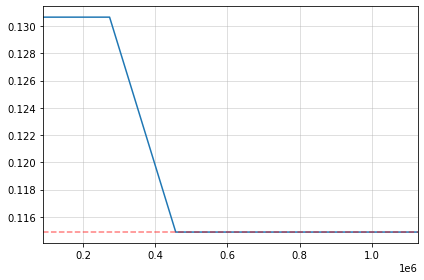

In [18]:
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [33]:
penalized, of_unpenalzied, S, Sp, Def = reservior_sim(X, D, I, Ev_mm, Smin, Smax)
stat_dic = {0: 'Unfeasible', 1: 'Feasible'}
test = penalized==of_unpenalzied
mes1 = f'''
================================
Solutions Stat:\t\t%s
================================
Penalzied OF:\t\t%.3f
OF: \t\t\t%.3f'''%(stat_dic[test], penalized, of_unpenalzied)
print(mes1)


Solutions Stat:		Feasible
Penalzied OF:		0.070
OF: 			0.070


In [19]:
#New
S_min_condition = np.all(S>=Smin)
S_max_condition = np.all(S<=Smax)
R_min_condition = np.all(X>=0)
R_max_condition = np.all(X<=D)
Smin_num = np.sum(S<Smin)
Smax_num = np.sum(S>Smax)
Rmin_num = np.sum(X<0)
Rmax_num = np.sum(X>D)
penalty_1 = np.sum(np.where(S<Smin,Smin-S,0))
penalty_2 = np.sum(np.where(S>Smax,S-Smax,0))
penalty_3 = np.sum(np.where(X<0,-X,0))
penalty_4 = np.sum(np.where(X>D,X>D,0))

print(f'''
Condition test summary: ====================================================
R_max_condition is %s\twith %d # of violation[s]; Applied Penalty [P4]: %d
R_min_condition is %s\twith %d # of violation[s]; Applied Penalty [P3]: %d
S_max_condition is %s\twith %d # of violation[s]; Applied Penalty [P2]: %d
S_min_condition is %s\twith %d # of violation[s]; Applied Penalty [P1]: %d
============================================================================='''%(R_max_condition, Rmax_num, penalty_4, 
                                                                                  R_min_condition, Rmin_num, penalty_3,
                                                                                  S_max_condition, Smax_num, penalty_2,
                                                                                  S_min_condition, Smin_num, penalty_1))


Condition test summary: ====================================================
R_max_condition is True	with 0 # of violation[s]; Applied Penalty [P4]: 0
R_min_condition is True	with 0 # of violation[s]; Applied Penalty [P3]: 0
S_max_condition is True	with 0 # of violation[s]; Applied Penalty [P2]: 0
S_min_condition is True	with 0 # of violation[s]; Applied Penalty [P1]: 0


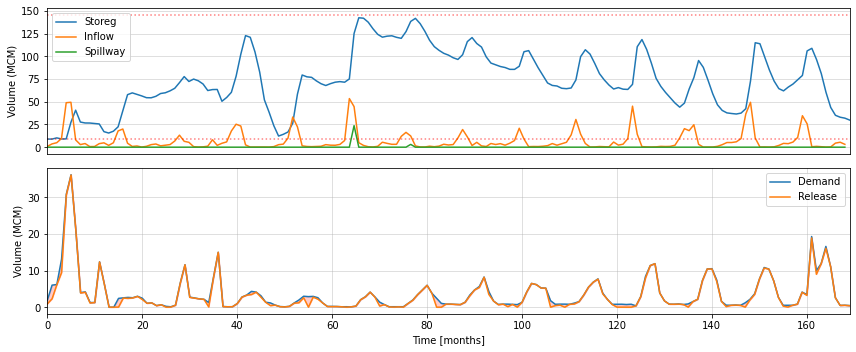

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(2,1,1)
fig = plt.plot(S,label='Storeg')
fig = plt.plot(I, label='Inflow')
fig = plt.plot(Sp, label='Spillway')
fig = plt.axhline(Smin, ls=':', alpha=.5, c='r')
fig = plt.axhline(Smax, ls=':', alpha=.5, c='r')
fig = plt.margins(0, .05)
fig = plt.ylabel('Volume (MCM)')
fig = plt.legend(loc='best')
fig = plt.grid(alpha = .5)
fig = plt.xticks([])

plt.subplot(2,1,2)
fig = plt.plot(D, label='Demand')
fig = plt.plot(X, label='Release')
fig = plt.fill_between(np.arange(len(X)), D, X, color='r', alpha=.2)
fig = plt.margins(0, .05)
fig = plt.xlabel('Time [months]')
fig = plt.ylabel('Volume (MCM)')
fig = plt.legend(loc='best')
fig = plt.grid(alpha = .5)
plt.tight_layout()

In [36]:
rel_vol = reliability_vol(X, D)
rel_pr = reliability_prob(X, D)
res_prob = resiliancy(X, D)

mes = f'''Reliability Volumetric:\t\t%.3f
Reliability [Probability]:\t%.3f
Resiliancy [Probability]:\t%.3f'''%(rel_vol, rel_pr, res_prob)
print(mes)

Reliability Volumetric:		0.930
Reliability [Probability]:	0.029
Resiliancy [Probability]:	0.024


Bulk Runs

In [14]:
pop_size_min, pop_size_max = 50, 150
iteration_min, iteration_max = 300, 500

In [15]:
num_runs = 7
alg_name = 'STML'

stat_dic = {0: 'Unfeasible', 1: 'Feasible'}

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'Solution Stat', 'Penalties'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE, setting, setting_list, nums = mega_algorithem(obj_func, min_val, max_val,
                                                                            num_variables, pop_size_min,
                                                                            pop_size_max, iteration_min,
                                                                            iteration_max)
    end_time = time.time()
    penalized, of_unpenalzied, S, Sp, Def = reservior_sim(X, D, I, Ev_mm, Smin, Smax)
    p_1 = np.sum(np.where(S<Smin,Smin-S,0))
    p_2 = np.sum(np.where(S>Smax,S-Smax,0))
    p_3 = np.sum(np.where(X<0,-X,0))
    p_4 = np.sum(np.where(X>D,X>D,0))
    test = penalized==of_unpenalzied
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'Solution Stat': stat_dic[test],
                                            'Parameters':{'P1':p_1,'P2':p_2, 'P3':p_3, 'P4':p_4}},
                                           ignore_index=True)
    print('[%d] Best of: %.2f; \t time: %.2f s; \t Feasible status: %s'%(i+1, best_of, (end_time-start_time), stat_dic[test]))
overall_result.to_csv('%s_%druns_results.csv'%(alg_name,num_runs))

[1] Best of: 0.12; 	 time: 11291.62 s; 	 Feasible status: Feasible
[2] Best of: 0.11; 	 time: 10167.57 s; 	 Feasible status: Feasible
[3] Best of: 0.11; 	 time: 8620.88 s; 	 Feasible status: Feasible
[4] Best of: 0.07; 	 time: 20424.01 s; 	 Feasible status: Feasible
[5] Best of: 0.08; 	 time: 13489.66 s; 	 Feasible status: Feasible
[6] Best of: 0.10; 	 time: 24796.88 s; 	 Feasible status: Feasible
[7] Best of: 0.11; 	 time: 11237.48 s; 	 Feasible status: Feasible


##### II. TLBO

In [14]:
def init_genrator(min_val, max_val, num_variables, pop_size):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = np.apply_along_axis(obj_func, 1, pop)
    indeces = np.argsort(results)
    return pop[indeces]

def teacher_phase(pop, pop_size, obj_func):
    teacher = pop[0]
    center = np.mean(pop, axis=0)
    rand = np.random.uniform(0,1,size=(pop_size,1))
    teacher_factor = np.random.choice(np.arange(1,3), size=(pop_size,1))
    diff = rand*(teacher-center*teacher_factor)
    pop_new = pop + diff
    of = np.apply_along_axis(obj_func, 1, pop).reshape(-1,1)
    of_new = np.apply_along_axis(obj_func, 1, pop_new).reshape(-1,1)
    return np.where(of_new<of, pop_new, pop)
    
def learner_phase(pop, pop_size, obj_func):
    rand = np.random.uniform(0,1,size=(pop_size,1))
    pop_new = np.zeros_like(pop)
    for i in range(pop_size):
        x, y = np.sort(np.random.choice(np.arange(pop_size), size=2, replace=False))
        pop_new[i] = pop[i] + rand[i]*(pop[x]-pop[y])
    of = np.apply_along_axis(obj_func, 1, pop).reshape(-1,1)
    of_new = np.apply_along_axis(obj_func, 1, pop_new).reshape(-1,1)
    return np.where(of_new<of, pop_new, pop)

    
def teaching_learning_based_optimization(num_variables, min_val, max_val, pop_size, iteration, obj_func):
    NFE_value = 0
    NFE = np.zeros(iteration)
    results = np.zeros(iteration)
    pop = init_genrator(min_val, max_val, num_variables, pop_size)
    pop = sorting_pop(pop, obj_func)
    for i in range(iteration):
        pop = teacher_phase(pop, pop_size, obj_func)
        pop = sorting_pop(pop, obj_func)
        pop = learner_phase(pop, pop_size, obj_func)
        pop = sorting_pop(pop, obj_func)
        NFE_value += (3*pop_size)
        NFE[i] = NFE_value
        results[i] = obj_func(pop[0])
    return pop[0], obj_func(pop[0]), results, NFE

In [15]:
min_val, max_val = np.zeros_like(D), D
num_variables = len(D)

pop_size = 250
iteration = 3000 

In [30]:
start_time = time.time()

X, best_of, results, NFE = teaching_learning_based_optimization(num_variables, min_val, max_val,
                                                                pop_size, iteration, obj_func)
end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

Best OF ====================
0.15022533242651073
Variables ==================
[6.53680458e-02 3.64671531e-01 4.12735454e+00 1.24639210e+01
 3.05752645e+01 3.55963243e+01 2.09905745e+01 3.64372644e+00
 3.27255617e+00 8.21289605e-01 1.20434631e+00 1.20451393e+01
 6.07623004e+00 0.00000000e+00 0.00000000e+00 1.64301646e+00
 7.31078915e-01 2.51408351e+00 5.52926943e-01 2.65702489e+00
 1.23481415e+00 9.51159395e-01 7.21217401e-01 8.54739907e-03
 4.64436415e-01 1.40688831e-01 9.15630549e-02 4.78476906e-01
 5.95668863e+00 1.09477197e+01 2.72371290e+00 1.68261999e+00
 2.02417290e+00 1.01130494e-01 1.10278765e+00 8.00115429e+00
 1.47689016e+01 1.42788697e-02 4.54321610e-02 9.66704593e-02
 3.54550136e-01 1.13957693e+00 2.85660115e+00 2.43161155e+00
 3.15130877e+00 2.30847040e+00 2.79094196e-01 6.43671208e-01
 2.59523914e-01 1.07911504e-01 1.88251422e-02 1.38841778e-01
 4.92201220e-01 1.52964382e+00 2.80718931e+00 2.07208805e+00
 2.72593953e+00 7.31009885e-01 1.04477569e+00 3.05397113e-02
 7.8275

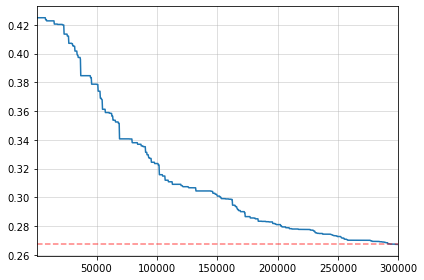

In [17]:
#New
#pop_size = 100
#iteration = 1000
fig = plt.plot(NFE, results)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of, ls='--', alpha=.5, c='r')
plt.tight_layout()

In [32]:
#New
#pop_size = 500
#iteration = 3000
penalized, of_unpenalzied, S, Sp, Def = reservior_sim(X, D, I, Ev_mm, Smin, Smax)
stat_dic = {0: 'Unfeasible', 1: 'Feasible'}
test = penalized==of_unpenalzied
mes1 = f'''
================================
Solutions Stat:\t\t%s
================================
Penalzied OF:\t\t%.3f
OF: \t\t\t%.3f'''%(stat_dic[test], penalized, of_unpenalzied)
print(mes1)


Solutions Stat:		Feasible
Penalzied OF:		0.150
OF: 			0.150


In [33]:
S_min_condition = np.all(S>=Smin)
S_max_condition = np.all(S<=Smax)
R_min_condition = np.all(X>=0)
R_max_condition = np.all(X<=D)
Smin_num = np.sum(S<Smin)
Smax_num = np.sum(S>Smax)
Rmin_num = np.sum(X<0)
Rmax_num = np.sum(X>D)
penalty_1 = np.sum(np.where(S<Smin,Smin-S,0))
penalty_2 = np.sum(np.where(S>Smax,S-Smax,0))
penalty_3 = np.sum(np.where(X<0,-X,0))
penalty_4 = np.sum(np.where(X>D,X>D,0))

print(f'''
Condition test summary: ====================================================
R_max_condition is %s\twith %d # of violation[s]; Applied Penalty [P4]: %d
R_min_condition is %s\twith %d # of violation[s]; Applied Penalty [P3]: %d
S_max_condition is %s\twith %d # of violation[s]; Applied Penalty [P2]: %d
S_min_condition is %s\twith %d # of violation[s]; Applied Penalty [P1]: %d
============================================================================='''%(R_max_condition, Rmax_num, penalty_4, 
                                                                                  R_min_condition, Rmin_num, penalty_3,
                                                                                  S_max_condition, Smax_num, penalty_2,
                                                                                  S_min_condition, Smin_num, penalty_1))


Condition test summary: ====================================================
R_max_condition is True	with 0 # of violation[s]; Applied Penalty [P4]: 0
R_min_condition is True	with 0 # of violation[s]; Applied Penalty [P3]: 0
S_max_condition is True	with 0 # of violation[s]; Applied Penalty [P2]: 0
S_min_condition is True	with 0 # of violation[s]; Applied Penalty [P1]: 0


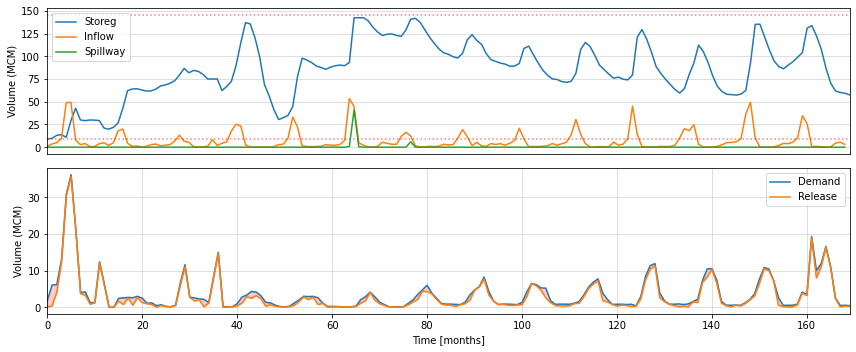

In [34]:
#New
#pop_size = 500
#iteration = 3000
plt.figure(figsize=(12,5))

plt.subplot(2,1,1)
fig = plt.plot(S,label='Storeg')
fig = plt.plot(I, label='Inflow')
fig = plt.plot(Sp, label='Spillway')
fig = plt.axhline(Smin, ls=':', alpha=.5, c='r')
fig = plt.axhline(Smax, ls=':', alpha=.5, c='r')
fig = plt.margins(0, .05)
fig = plt.ylabel('Volume (MCM)')
fig = plt.legend(loc='best')
fig = plt.grid(alpha = .5)
fig = plt.xticks([])

plt.subplot(2,1,2)
fig = plt.plot(D, label='Demand')
fig = plt.plot(X, label='Release')
fig = plt.fill_between(np.arange(len(X)), D, X, color='r', alpha=.2)
fig = plt.margins(0, .05)
fig = plt.xlabel('Time [months]')
fig = plt.ylabel('Volume (MCM)')
fig = plt.legend(loc='best')
fig = plt.grid(alpha = .5)
plt.tight_layout()

In [35]:
#New
#pop_size = 500
#iteration = 3000
rel_vol = reliability_vol(X, D)
rel_pr = reliability_prob(X, D)
res_prob = resiliancy(X, D)

mes = f'''Reliability Volumetric:\t\t%.3f
Reliability [Probability]:\t%.3f
Resiliancy [Probability]:\t%.3f'''%(rel_vol, rel_pr, res_prob)
print(mes)

Reliability Volumetric:		0.850
Reliability [Probability]:	0.012
Resiliancy [Probability]:	0.006


Bulk Runs

In [ ]:
num_runs = 7
alg_name = 'TLBO'


stat_dic = {0: 'Unfeasible', 1: 'Feasible'}

overall_result = pd.DataFrame(columns=['Run #', 'Algorithm', 'best_OF', 'NFE',
                                       'time (s)', 'Solution Stat', 'Penalties'])
for i in range(num_runs):
    start_time = time.time()
    X, best_of, results, NFE = teaching_learning_based_optimization(num_variables, min_val, max_val,
                                                                    pop_size, iteration, obj_func)
    end_time = time.time()
    penalized, of_unpenalzied, S, Sp, Def = reservior_sim(X, D, I, Ev_mm, Smin, Smax)
    p_1 = np.sum(np.where(S<Smin,Smin-S,0))
    p_2 = np.sum(np.where(S>Smax,S-Smax,0))
    p_3 = np.sum(np.where(X<0,-X,0))
    p_4 = np.sum(np.where(X>D,X>D,0))          
    test = penalized==of_unpenalzied
    overall_result = overall_result.append({'Run #': i+1, 'Algorithm':alg_name, 'best_OF':best_of,
                                            'NFE':NFE[-1], 'time (s)':end_time-start_time,
                                            'Solution Stat': stat_dic[test],
                                            'Parameters':{'P1':p_1,'P2':p_2, 'P3':p_3, 'P4':p_4}},
                                           ignore_index=True)
    print('[%d] Best of: %.2f; \t time: %.2f s; \t Feasible status: %s'%(i+1, best_of, (end_time-start_time), stat_dic[test]))
overall_result.to_csv('%s_%druns_results_new.csv'%(alg_name,num_runs))

[1] Best of: 0.18; 	 time: 6940.68 s; 	 Feasible status: Feasible
[2] Best of: 0.17; 	 time: 6971.93 s; 	 Feasible status: Unfeasible
[3] Best of: 0.16; 	 time: 6985.55 s; 	 Feasible status: Feasible
[4] Best of: 0.19; 	 time: 7007.14 s; 	 Feasible status: Feasible
[5] Best of: 0.17; 	 time: 6974.79 s; 	 Feasible status: Feasible
